# Text Analysis Homework 3
<br>
## Daxi Cheng, Jianjie Zheng, Reece Wooten, Nick Scheifler

In [45]:
import pandas as pd
import nltk
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx
from pandas import Series,DataFrame
warnings.filterwarnings("ignore")
%matplotlib inline  
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Task A

In [2]:
sent_scores = pd.read_csv('assignment 3 sentiment scores.csv')
sent_scores.head()

,ES,LS,RX,A8,A6,3series,5series,7series,XJ,Sclass
0,NaN,NaN,4.0,3.0,NaN,NaN,NaN,5.0,2.0,1.0
1,NaN,NaN,3.0,2.0,2.0,2.0,2.0,2.0,NaN,NaN
2,NaN,4.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,3.0
3,NaN,2.0,NaN,2.0,NaN,NaN,NaN,2.0,4.0,2.0
4,NaN,3.0,3.0,NaN,NaN,NaN,2.0,NaN,NaN,3.0


In [5]:
modelset=set(sent_scores.columns)

In [18]:
def newcompare(a,b):
    '''newcompare a and b to get the direction and weight
    if tie, then return noting'''
    maska=sent_scores[a].notnull()
    maskb=sent_scores[b].notnull()
    masked=sent_scores[maska&maskb]
    abmask=masked[masked[a]>masked[b]]
    if len(abmask)!=0:
        difab=round(sum(abmask[a]-abmask[b])/len(abmask),2)
        return (a,b,difab)
    else:
        return

In [20]:
from itertools import combinations
newcompare_result=[]
model_combine=list(combinations(modelset,2))
for i in model_combine:
    newcompare_result.append(newcompare(i[0],i[1]))
    newcompare_result.append(newcompare(i[1],i[0]))
newcompare_result=[str for str in newcompare_result if str not in [None]]

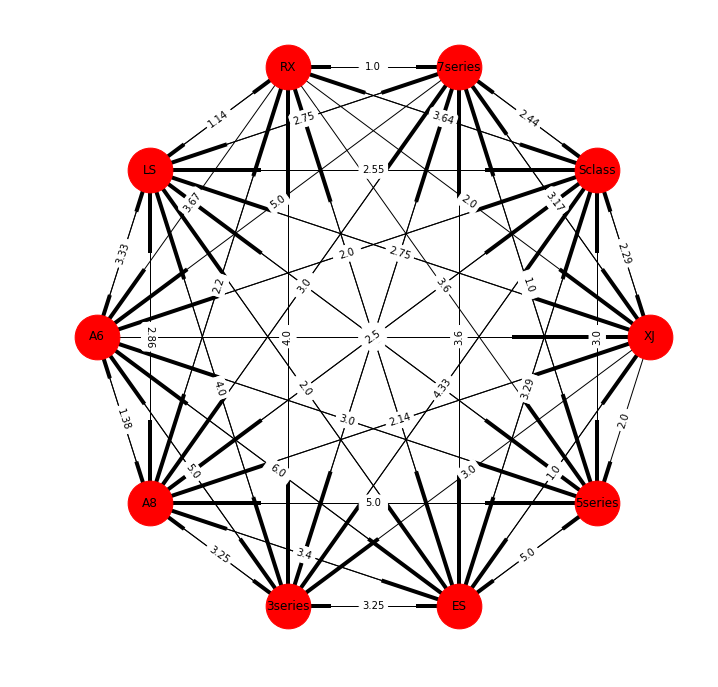

In [130]:
fig = plt.figure(figsize=(12, 12))
G = nx.MultiDiGraph() 
for i in newcompare_result:
    G.add_edge(i[0], i[1], weight=i[2])
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
pos = nx.shell_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)    
nx.draw(G, pos=pos, arrows=True, with_labels=True,node_size=2000)

plt.show()

Weighted graph:https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html

# Task B

In [22]:
models = ['A6','A8','3series','5series','7series','XJ','ES','LS','RX','Sclass']
sales = [20000,12000,220000,60000,14000,6600,135000,30000,120000,25000]
sales_df = pd.DataFrame({
    'Model':models,
    'Sales':sales
})
sales_df

,Model,Sales
0,A6,20000
1,A8,12000
2,3series,220000
3,5series,60000
4,7series,14000
5,XJ,6600
6,ES,135000
7,LS,30000
8,RX,120000
9,Sclass,25000


In [47]:
PR = nx.Graph()
for u,v,d in G.edges(data=True):
    w = d['weight']
    if PR.has_edge(u,v):
        PR[u][v]['weight'] += w
    else:
        PR.add_edge(u,v,weight=w)

In [49]:
w_pr = nx.pagerank(PR)
w_pr=pd.DataFrame(Series(w_pr),columns=['PR']).reset_index()
uw_pr = nx.pagerank(PR,weight='None')
uw_pr=pd.DataFrame(Series(uw_pr),columns=['PR']).reset_index()

In [188]:
merge1=pd.merge(left=uw_pr,right=w_pr,left_on='index',right_on='index',suffixes=['_unweighted','_weighted'])
resultQb=pd.merge(left=merge1,right=sales_df,left_on='index',right_on='Model')[['Model','PR_unweighted' ,'PR_weighted','Sales']]
resultQb

,Model,PR_unweighted,PR_weighted,Sales
0,3series,0.092056,0.120342,220000
1,5series,0.092056,0.096648,60000
2,7series,0.101986,0.105182,14000
3,A6,0.101986,0.099574,20000
4,A8,0.101986,0.106371,12000
5,ES,0.101986,0.111851,135000
6,LS,0.101986,0.100456,30000
7,RX,0.101986,0.086458,120000
8,Sclass,0.101986,0.102859,25000
9,XJ,0.101986,0.070260,6600


In [62]:
print 'unweighted corr=',np.corrcoef(resultQb['PR_unweighted'],resultQb['Sales'])[1,0]
print 'weighted corr=',np.corrcoef(resultQb['PR_weighted'],resultQb['Sales'])[1,0]

unweighted corr= -0.560559978193
weighted corr= 0.484373753944


Because in unweighted graph, we just treat all the link as 1 or 0, so if one model has a quite small weight from 
another model, this would be treated equally as a really large weight. Page rank is designed upon the notion of< different link is not weighted equal, so if we use unweighted page rank, we will just lose all the information on
**the level of sentiment difference** between models.

# Part C

In [78]:
from nltk.corpus import stopwords
'''
Define our own stop words list that keeps useful stop words
'''
stop = stopwords.words('english')
kept = ["t","cannot","no","nor","not","too","so","very"]
stop = [word for word in stop if word not in kept]

In [90]:
def model_replace(s):
    '''
    This function replace the - since otherwise it would be cut into two tokens and treated differently
    '''
    s=s.replace('-series','series')
    s=s.replace('-class','class')
    return s

In [91]:
from nltk.tokenize import RegexpTokenizer
def StringProcess(s):
    '''
    This function transform a sentence into a list of tokenized words withous the useless stop words
    '''
    s=s.lower()
    s=model_replace(s)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens=tokenizer.tokenize(s)
    tokens=[word for word in tokens if word not in stop ]
    return tokens

In [98]:
models=[word.lower() for word in models]
models

['a6', 'a8', '3series', '5series', '7series', 'xj', 'es', 'ls', 'rx', 'sclass']

In [135]:
def mention_list(s):
    '''
    This function get the list of which model is mentioned in a review
    '''
    l=StringProcess(s)
    model_list =[]
    for i in models:
        if i in l:
            model_list.append(i)
    return model_list

In [263]:
def get_near_words(Model, tokens):
    '''
    This function get the list of words that some words before and some after the model in each review
    '''
    modelindex=tokens.index(Model)
    near_words=tokens[modelindex-3:modelindex+3]
    return near_words


In [264]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()
def get_sent_score(l):
    '''
    This function takes the list of words we got and convert it to a sentence-like thing 
    and use VADER to analyse the sentiment score
    '''
    s=' '.join(l)
    score = sia.polarity_scores(s)['compound']
    return score

In [265]:
reviews=pd.read_csv('Combined reviews.csv')
reviews.head()

,Review
0,":P I like you, Merc. You make me laugh! If Mat..."
1,I am surprised that I did not find any discuss...
2,I am surprised that I did not find any discuss...
3,. . .let me see if I am following along correc...
4,". . .now hold on a minute. A ""current"" A6 4.2 ..."


In [266]:
# initialize the whole dataframe to receive sentiment score data
for i in models:
    reviews[i] = np.nan
reviews=reviews.drop_duplicates()
reviews=reviews.reset_index()

In [267]:
for i in range(reviews.shape[0]):
    menlist=mention_list(reviews.loc[i]['Review'])
    token=StringProcess(reviews.loc[i]['Review'])
    for j in menlist:
        nearwords=get_near_words(j,token)
        reviews.loc[i,j]=get_sent_score(nearwords)

In [268]:
def newnewcompare(a,b):
    '''newcompare a and b to get the direction and weight
    if tie, then return noting'''
    maska=reviews[a].notnull()
    maskb=reviews[b].notnull()
    masked=reviews[maska&maskb]
    abmask=masked[masked[a]>masked[b]]
    if len(abmask)!=0:
        difab=round(sum(abmask[a]-abmask[b])/len(abmask),2)
        return (a,b,difab)
    else:
        return

In [269]:
our_newcompare_result=[]
model_combine=list(combinations(models,2))
for i in model_combine:
    our_newcompare_result.append(newcompare(i[0],i[1]))
    our_newcompare_result.append(newcompare(i[1],i[0]))
our_newcompare_result=[str for str in our_newcompare_result if str not in [None]]

In [270]:
newG = nx.MultiDiGraph() 
for i in our_newcompare_result:
    newG.add_edge(i[0], i[1], weight=i[2])
edge_labels=dict([((u,v,),d['weight']) for u,v,d in newG.edges(data=True)])

In [271]:
newPR = nx.Graph()
for u,v,d in newG.edges(data=True):
    w = d['weight']
    if newPR.has_edge(u,v):
        newPR[u][v]['weight'] += w
    else:
        newPR.add_edge(u,v,weight=w)
new_w_pr = nx.pagerank(newPR)
new_w_pr=pd.DataFrame(Series(new_w_pr),columns=['our_PR']).reset_index()

In [272]:
def get_lower(s):
    return s.lower()
resultQb['mindex']=resultQb['Model'].map(get_lower)

In [273]:
new_result=pd.merge(left=resultQb,right=new_w_pr,left_on='mindex',right_on='index')
new_result=new_result[['Model','PR_unweighted','PR_weighted','our_PR','Sales']]
new_result

,Model,PR_unweighted,PR_weighted,our_PR,Sales
0,3series,0.092056,0.120342,0.105740,220000
1,5series,0.092056,0.096648,0.108683,60000
2,7series,0.101986,0.105182,0.098559,14000
3,A6,0.101986,0.099574,0.110004,20000
4,A8,0.101986,0.106371,0.103344,12000
5,ES,0.101986,0.111851,0.060096,135000
6,LS,0.101986,0.100456,0.105055,30000
7,RX,0.101986,0.086458,0.098778,120000
8,Sclass,0.101986,0.102859,0.110451,25000
9,XJ,0.101986,0.070260,0.099291,6600


In [274]:
print 'our weighted corr=',np.corrcoef(new_result['our_PR'],new_result['Sales'])[1,0]

our weighted corr= -0.33083272853


In [284]:
test=new_result.drop([0,5,7])
print 'After removing the outliers, our weighted corr=',np.corrcoef(test['our_PR'],test['Sales'])[1,0]

After removing the outliers, our weighted corr= 0.575752050068


We guess that there do exist some outliers in the relationship since as we get the words, some cars such as BMW 3-series are just people complain about a lot and compared with some really nice cars really often, but since they are just the entry level of BMW brand at a cheap price, people still purchase a lot.